In [5]:
import os
import time
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt 
from matplotlib.colors import LogNorm, Normalize
from itertools import product
import scipy.stats as stats
from scipy.optimize import curve_fit


In [ ]:
# Data provided by Smith et al. 2024
smith_data = pd.read_csv("../data/smith2024_tidy-data.csv")
smith_data.head()

/var/folders/jt/pfj3_rxs1ld0n_4wg3842s1w0000gn/T/ipykernel_85533/3175713228.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  smith_data = pd.read_csv("../data/smith2024_tidy-data.csv")


,Time,Well,OD600,Plate,PlateTrue,Rep,Strain,Amoxicillin,Chlorothalonil,Diflufenican,Glyphosate,Imidacloprid,Metaldehyde,Oxytetracycline,Tebuconazole,Complexity,PlateWell,TruePlateWell,Strain_nice
0,0.001667,B10,0.096,1,1,1,74,1,0,0,1,0,1,0,0,3,1B10,1B10,IL 74
1,1.001389,B10,0.097,1,1,1,74,1,0,0,1,0,1,0,0,3,1B10,1B10,IL 74
2,2.001667,B10,0.097,1,1,1,74,1,0,0,1,0,1,0,0,3,1B10,1B10,IL 74
3,3.001667,B10,0.097,1,1,1,74,1,0,0,1,0,1,0,0,3,1B10,1B10,IL 74
4,4.001944,B10,0.098,1,1,1,74,1,0,0,1,0,1,0,0,3,1B10,1B10,IL 74


In [ ]:

# Data processing: Here I created a dataframe to find maximum OD600 for each bacterial strain under different numbers of chemicals
max_od_df = smith_data.groupby(['Strain_nice', 'Complexity'])['OD600'].max().reset_index()

mixture_strains = max_od_df['Strain_nice'].str.contains('Mixture', regex=False) 

# Here, for the convenience of future data analysis, I created a column to designate rows that have mixture of strains. 
max_od_df['Mixture'] = mixture_strains.astype(int)

print(max_od_df)


     Strain_nice  Complexity  OD600  Mixture
0        E. coli           0  1.093        0
1        E. coli           1  1.111        0
2        E. coli           2  1.101        0
3        E. coli           3  1.096        0
4        E. coli           4  1.122        0
..           ...         ...    ...      ...
112  V. fischeri           4  1.146        0
113  V. fischeri           5  1.144        0
114  V. fischeri           6  1.065        0
115  V. fischeri           7  1.038        0
116  V. fischeri           8  0.787        0

[117 rows x 4 columns]


In [ ]:
# I compared single strains vs. mixture by using two sample t test. 
mixture_od = max_od_df[max_od_df['Mixture'] == 1]['OD600']
single_od = max_od_df[max_od_df['Mixture'] == 0]['OD600']

t_stat_od, p_value_od = stats.ttest_ind(mixture_od, single_od, equal_var=False)

print("Two-sample t-stest results for OD600:")
print("t-statistic:", t_stat_od)
print("p-value:", p_value_od)

Two-sample t-stest results for OD600:
t-statistic: 6.328975163391054
p-value: 4.6266584141572035e-05


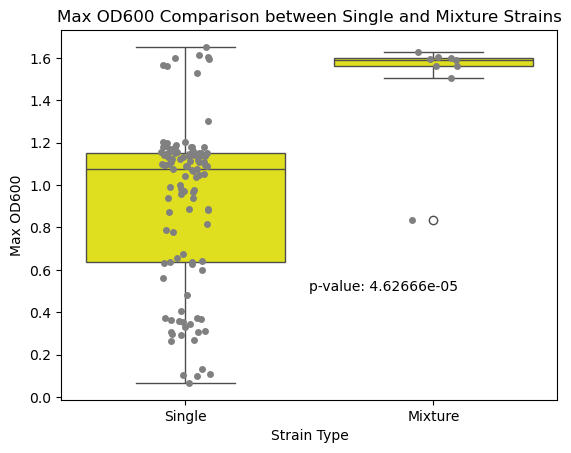

In [ ]:
# Here I plot the figure. 

max_od_df['Mixture_str'] = max_od_df['Mixture'].map({0: 'Single', 1: 'Mixture'})

ax = sns.boxplot(x='Mixture_str', y='OD600', data=max_od_df, color='yellow')
sns.stripplot(x='Mixture_str', y='OD600', data=max_od_df, jitter=True, color='grey', ax=ax)



plt.xlabel("Strain Type")
plt.ylabel("Max OD600")
plt.title("Max OD600 Comparison between Single and Mixture Strains")
plt.text(0.5, 0.5, f"p-value: {np.round(p_value_od, 10)}")


plt.show()

In [ ]:
# I exported the dataframe as table in csv
max_od_df.to_csv('max_od_df.csv', index=False)

In [ ]:
# I conducted logistic fit for different bacterial strains under increasing number of chemicals 
def logistic_growth_func(t, r, K, M0, B=0):
    return M0 / (M0 / K + (1 - M0 / K) * np.exp(-r * t)) + B

def logistic_growth_inf(t_data, M_data, viz=False): 
    try:
        popt, _ = curve_fit(
            logistic_growth_func, t_data, M_data, 
            bounds=((0, 0, 0, 0), (np.inf, 1.5 * np.max(M_data), np.max(M_data), np.max(M_data)))
        )
        r, K, M0, B = popt
    except:
        if viz:
            print("Unable to fit logistic function; returning -1")
        return [-1, -1, -1, -1]
    
    return [r, K, M0, B]

growth_params = []

for (strain, complexity), group in smith_data.groupby(['Strain_nice', 'Complexity']):
    t_data = group['Time'].values
    M_data = group['OD600'].values
    
    if len(t_data) > 5: 
        r, K, M0, B = logistic_growth_inf(t_data, M_data)
        growth_params.append([strain, complexity, r, K, M0, B])

growth_df = pd.DataFrame(growth_params, columns=['Strain_nice', 'Complexity', 'r', 'K', 'M0', 'B'])
growth_df['Mixture'] = growth_df['Strain_nice'].str.contains('Mixture', regex=False).astype(int)

print(growth_df)

     Strain_nice  Complexity         r         K        M0             B  \
0        E. coli           0  0.096452  0.952614  0.054506  1.348788e-02   
1        E. coli           1  0.099043  0.971538  0.055468  6.392933e-03   
2        E. coli           2  0.095212  0.959672  0.063645  6.429246e-11   
3        E. coli           3  0.098931  0.922219  0.051767  1.424508e-02   
4        E. coli           4  0.101983  0.904536  0.043642  2.611083e-02   
..           ...         ...       ...       ...       ...           ...   
112  V. fischeri           4  0.094998  0.862385  0.153544  8.545431e-15   
113  V. fischeri           5  0.061653  0.794113  0.169287  3.736928e-15   
114  V. fischeri           6  0.036327  1.027058  0.158071  1.908491e-12   
115  V. fischeri           7  0.057275  1.068835  0.032085  9.534337e-02   
116  V. fischeri           8  0.154815  0.658981  0.000324  1.030980e-01   

     Mixture  
0          0  
1          0  
2          0  
3          0  
4          0

In [16]:
growth_df.to_csv('growth_df.csv', index=False)

In [ ]:
# Two sample t test
mixture_r = growth_df[max_od_df['Mixture'] == 1]['r']
single_r = growth_df[max_od_df['Mixture'] == 0]['r']

t_stat_r, p_value_r = stats.ttest_ind(mixture_r, single_r, equal_var=False)

print("Two-sample t-stest results for growth rate (r):")
print("t-statistic:", t_stat_r)
print("p-value:", p_value_r)

Two-sample t-stest results for growth rate (r):
t-statistic: 1.2515720628916482
p-value: 0.23046126980311013


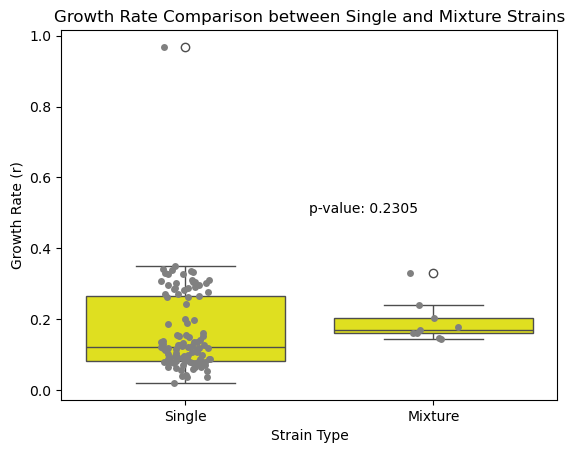

In [13]:
growth_df['Mixture_str'] = growth_df['Mixture'].map({0: 'Single', 1: 'Mixture'})

ax = sns.boxplot(x='Mixture_str', y='r', data=growth_df, color='yellow')
sns.stripplot(x='Mixture_str', y='r', data=growth_df, jitter=True, color='grey', ax=ax)



plt.xlabel("Strain Type")
plt.ylabel("Growth Rate (r)")
plt.title("Growth Rate Comparison between Single and Mixture Strains")
plt.text(0.5, 0.5, f"p-value: {np.round(p_value_r, 4)}")


plt.show()

<Axes: xlabel='Complexity', ylabel='r'>

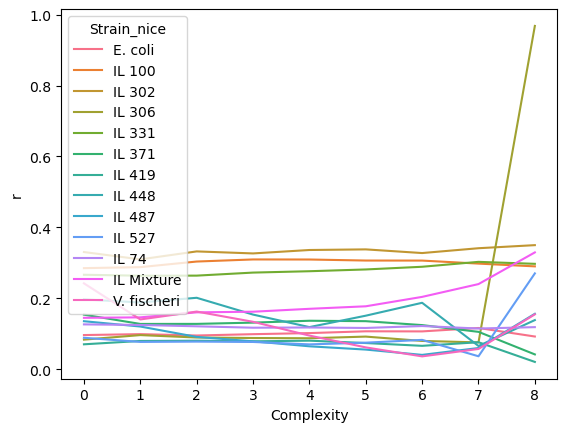

In [14]:
sns.lineplot(data=growth_df, x='Complexity', y='r', hue='Strain_nice')

<Axes: xlabel='Complexity', ylabel='OD600'>

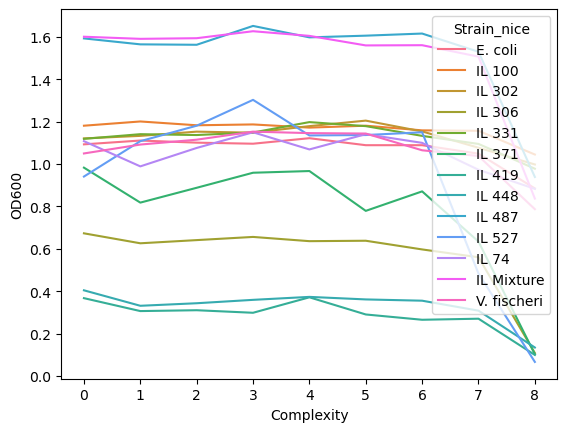

In [15]:
sns.lineplot(data=max_od_df, x='Complexity', y='OD600', hue='Strain_nice')